Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

Dataset load and preprocessing

In [9]:
data = pd.read_excel("included_2016_nn_dataset_input.xlsx")

# data = data.drop('Zapis Merania', axis=1)
data = data.drop(columns=["Datum do", 'Datum od'])

data = data.astype(float)

data = data.drop(columns=["Datum do", 'Datum od'])
data.dropna(inplace=True)

X = data.drop(columns=["Rozsev 0-5"])
y = data["Rozsev 0-5"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Splitting the dataset into training, testing, and validation sets
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.35, random_state=1633, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=1633, shuffle=True)

y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

train = TensorDataset(X_train, y_train)
test = TensorDataset(X_test, y_test)
val = TensorDataset(X_val, y_val)

# Vytvorenie dataloaders pre trénovaciu a testovaciu sadu
train_loader = DataLoader(train, batch_size=64, shuffle=False)
test_loader = DataLoader(test, batch_size=64, shuffle=False)
validation_loader = DataLoader(val, batch_size=64, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Tiny analysis

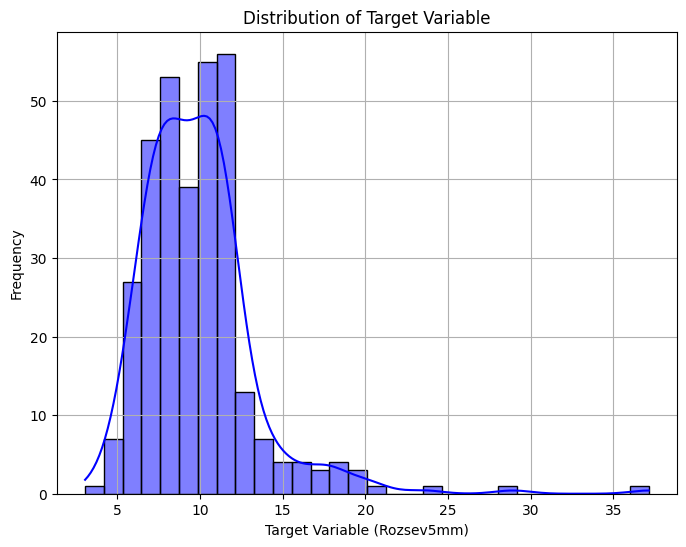

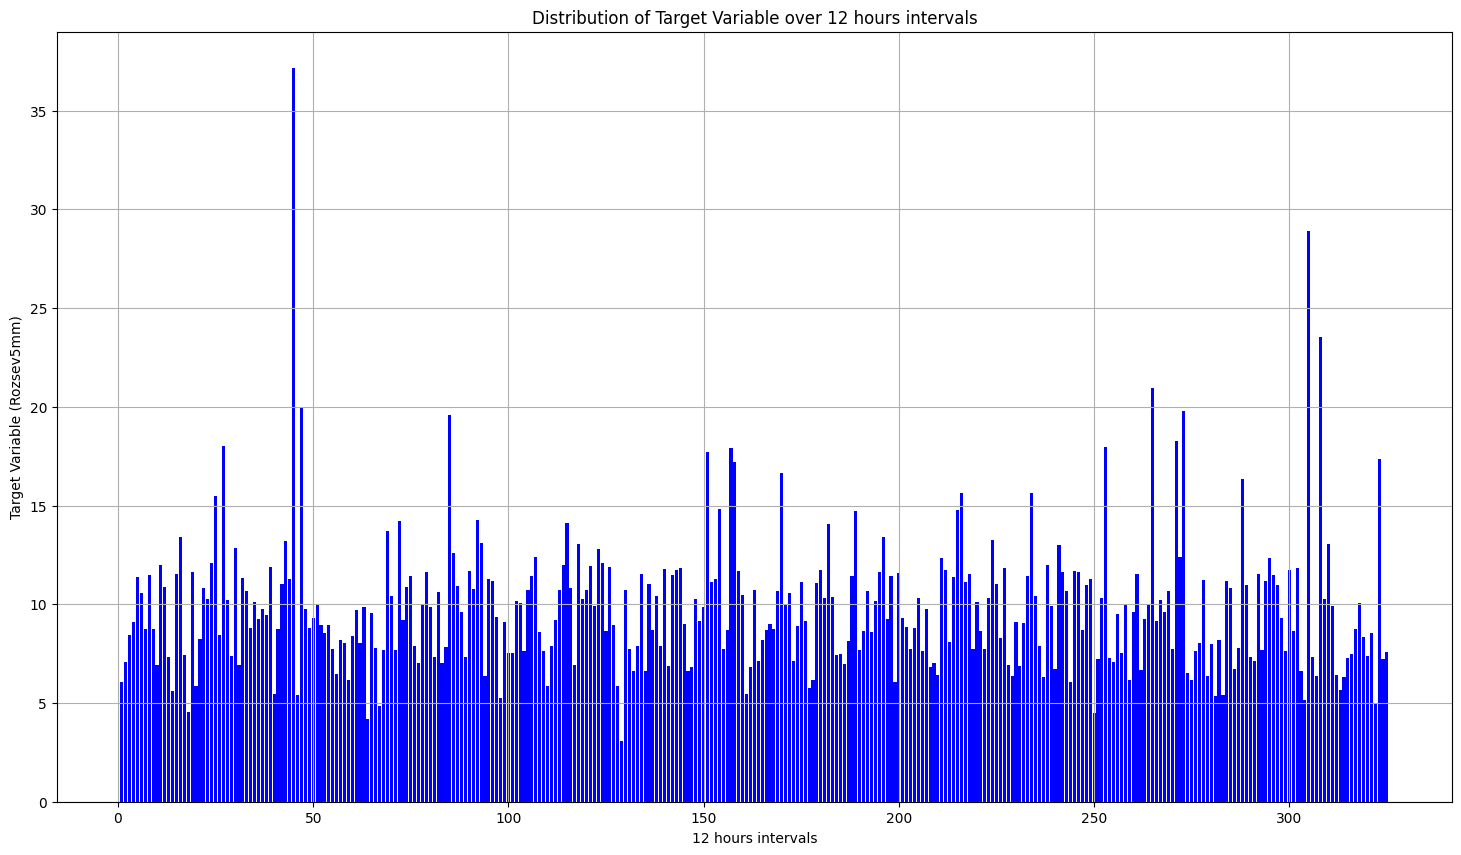

In [5]:
plt.figure(figsize=(8, 6))
sns.histplot(y_train.numpy(), kde=True, bins=30, edgecolor='black', color="blue")
plt.xlabel('Target Variable (Rozsev5mm)')
plt.ylabel('Frequency')
plt.title('Distribution of Target Variable')
plt.grid(True)
plt.show()

plt.figure(figsize=(18, 10))
plt.bar(range(1, len(y_train) + 1), y_train.numpy().flatten(), color='blue')
plt.xlabel('12 hours intervals')
plt.ylabel('Target Variable (Rozsev5mm)')
plt.title('Distribution of Target Variable over 12 hours intervals')
plt.grid(True)
plt.show()

**LSTM**

In [6]:
class Model_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(Model_LSTM, self).__init__()

        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.4)

        self.fc1 = nn.Linear(hidden_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 1)

        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.15)
        self.dropout3 = nn.Dropout(0.1)

    def forward(self, x):

        # Set initial hidden states and cell states for LSTM
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0,c0))

        # out: tensor of shape (batch_size, seq_length, hidden_size)
        # Decode the hidden state of the last time step
        out = out[:, -1, :]

        out = F.relu(self.fc1(out))
        out = self.dropout1(out)
        out = F.relu(self.fc2(out))
        out = self.dropout2(out)
        out = F.relu(self.fc3(out))
        out = self.dropout3(out)
        out = F.relu(self.fc4(out))
        out = self.dropout3(out)
        out = self.fc5(out)

        return out

In [5]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, dropout):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, dropout = 0.3, batch_first=True)

        self.fc = nn.Linear(hidden_dim, 32)
        self.fc1 = nn.Linear(32, 1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # Forward propagation through LSTM layer
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.dropout(out)
        # Index hidden state of last time step
        out = nn.functional.relu(self.fc(out[:, -1, :]))
        #out = out[:, -1, :]
        out = self.dropout(out)
        #out = self.fc(out)
        #out = self.dropout(out)
        out = self.fc1(out)
        return out

FNN

In [6]:
class FNNModel(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(FNNModel, self).__init__()

        self.fc1 = nn.Linear(hidden_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 1)

        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.15)
        self.dropout3 = nn.Dropout(0.1)

    def forward(self, x):
        out = F.relu(self.fc1(x))
        out = self.dropout1(out)
        out = F.relu(self.fc2(out))
        out = self.dropout2(out)
        out = F.relu(self.fc3(out))
        out = self.dropout3(out)
        out = F.relu(self.fc4(out))
        out = self.dropout3(out)
        out = self.fc5(out)

        return out

**TRAIN FUNCTION**

In [24]:
def train_model(model, criterion, optimizer, train_loader, validation_loader, X_train, num_epochs):
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
      model.train()
      running_loss = 0.0
      for i, batch in enumerate(train_loader):

          data = batch[0].to(device)
          labels = batch[1].to(device)

          data = data.view(-1, 1, len(X.columns)).requires_grad_()

          optimizer.zero_grad()
          outputs = model(data)

          loss = criterion(outputs.squeeze(), labels)
          loss.backward()
          optimizer.step()
          running_loss += loss.item() * data.size(0)

      # Calculate average training loss for the epoch

      train_loss = running_loss / len(train_loader.dataset)
      train_losses.append(train_loss)

      # Validation
      model.eval()  
      validation_loss = 0.0
      for data_val, labels_val in validation_loader:
        data_val = data_val.view(-1, 1, len(X.columns))
        outputs_val = model(data_val)
        loss_val = criterion(outputs_val.squeeze(), labels_val)
        validation_loss += loss_val.item() * data_val.size(0)  

      validation_loss /= len(validation_loader.dataset)  
      val_losses.append(validation_loss)
    #   print('Validation Loss: {}'.format(validation_loss))

      # Print progress every 20th epoch or at the end
      if epoch % 20 == 0 or epoch == num_epochs - 1:
          print(f'Epoch [{epoch}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {validation_loss:.4f}')

    return train_losses, val_losses


In [ ]:
def train_function(model, criterion, optimizer, train_loader, validation_loader, X_train, num_epochs):
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        model.train()
        for i, (data, labels) in enumerate(train_loader):
        
            data = data.view(-1, 1, len(X_val)).requires_grad_()
            
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs.squeeze(), labels)
            
            loss.backward()
            optimizer.step()
            
            if epoch % 20 == 0:
                train_losses.append(loss.item())

                # Výpis straty
                print('Epoch: {}. Loss: {}'.format(epoch, loss.item()))

                model.eval()  
                validation_loss = 0.0
                for data_val, labels_val in validation_loader:
                    data_val = data_val.view(-1, 1, len(X_val))
                    outputs_val = model(data_val)
                    loss_val = criterion(outputs_val.squeeze(), labels_val)
                    validation_loss += loss_val.item() * data_val.size(0)  

                validation_loss /= len(validation_loader.dataset)  
                val_losses.append(validation_loss)
                print('Validation Loss: {}'.format(validation_loss))
    return train_losses, val_losses

**Training**

In [25]:
n_samples, n_features = X.shape

model = Model_LSTM(n_features, 512, 3).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

Epoch [0/200], Train Loss: 107.9786, Val Loss: 59.1117
Epoch [20/200], Train Loss: 13.8731, Val Loss: 25.1033
Epoch [40/200], Train Loss: 11.3180, Val Loss: 21.8241
Epoch [60/200], Train Loss: 10.2006, Val Loss: 19.6456
Epoch [80/200], Train Loss: 7.5653, Val Loss: 18.4821
Epoch [100/200], Train Loss: 8.6370, Val Loss: 18.0667
Epoch [120/200], Train Loss: 7.4546, Val Loss: 21.3087
Epoch [140/200], Train Loss: 4.1806, Val Loss: 16.6893
Epoch [160/200], Train Loss: 4.1124, Val Loss: 21.4254
Epoch [180/200], Train Loss: 5.0029, Val Loss: 17.3467
Epoch [199/200], Train Loss: 3.4592, Val Loss: 16.3359


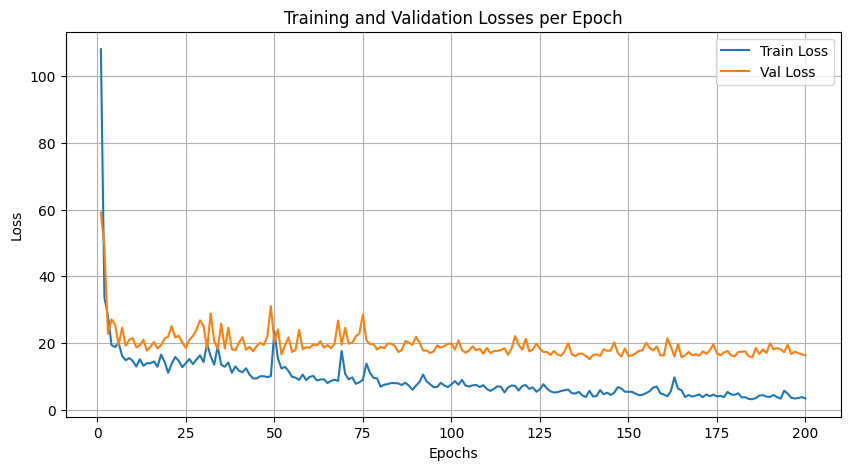

In [26]:
# Train the model
num_epochs = 200
train_losses, val_losses = train_model(model, criterion, optimizer, train_loader, validation_loader, X_train, num_epochs)

# Plotting the losses
epochs = range(1, num_epochs+1)
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses per Epoch')
plt.legend()
plt.grid(True)
plt.show()

Predicted vs Actual for LSTM

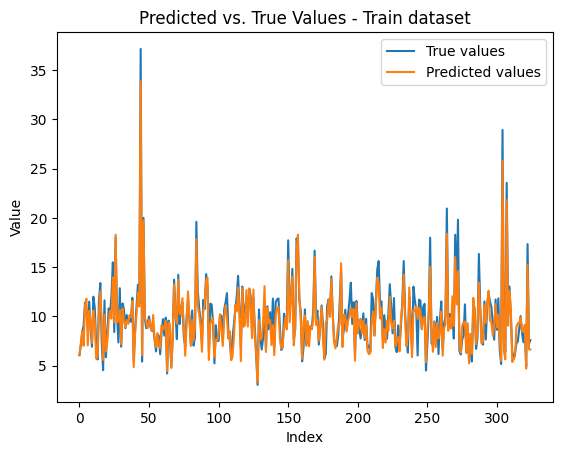

In [21]:
model.eval()

predicted_values = []
true_values = []

with torch.no_grad():
    for data, labels in train_loader:
        data = data.view(-1, 1, len(X.columns))
        outputs = model(data)
        predicted_values.extend(outputs.cpu().numpy())
        true_values.extend(labels.cpu().numpy())

plt.plot(true_values, label="True values")
plt.plot(predicted_values, label="Predicted values")
plt.xlabel("Index")
plt.ylabel("Value")
plt.title("Predicted vs. True Values - Train dataset")
plt.legend()
plt.show()

In [23]:
model.eval()

with torch.no_grad():
    for data, labels in train_loader:
        outputs = model(data.view(-1, 1, len(X.columns)))
        
        for i in range(len(outputs)):
            print("Trenovanie | Predikovaná hodnota:", outputs[i].item(), "| Skutočná hodnota:", labels[i].item())

Trenovanie | Predikovaná hodnota: 6.108914375305176 | Skutočná hodnota: 6.059999942779541
Trenovanie | Predikovaná hodnota: 7.233644962310791 | Skutočná hodnota: 7.059999942779541
Trenovanie | Predikovaná hodnota: 8.491503715515137 | Skutočná hodnota: 8.430000305175781
Trenovanie | Predikovaná hodnota: 7.021944046020508 | Skutočná hodnota: 9.09000015258789
Trenovanie | Predikovaná hodnota: 11.115185737609863 | Skutočná hodnota: 11.399999618530273
Trenovanie | Predikovaná hodnota: 11.79262638092041 | Skutočná hodnota: 10.569999694824219
Trenovanie | Predikovaná hodnota: 7.0546488761901855 | Skutočná hodnota: 8.760000228881836
Trenovanie | Predikovaná hodnota: 10.558146476745605 | Skutočná hodnota: 11.5
Trenovanie | Predikovaná hodnota: 9.653729438781738 | Skutočná hodnota: 8.729999542236328
Trenovanie | Predikovaná hodnota: 7.322477340698242 | Skutočná hodnota: 6.920000076293945
Trenovanie | Predikovaná hodnota: 10.615574836730957 | Skutočná hodnota: 12.0
Trenovanie | Predikovaná hodnot